In [1]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import PIL.Image
import matplotlib.pyplot as plt
import time
import os
import copy

import dnnlib
import legacy

torch.cuda.set_device(1)
os.environ['CUDA_VISIBLE_DEVICES'] = '1'


device = torch.device('cuda')
with dnnlib.util.open_url("model/ffhq.pkl") as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore

device = torch.device('cuda')
with dnnlib.util.open_url("model/ffhq.pkl") as f:
    G_style = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore

In [2]:
# z = torch.from_numpy(np.random.randn(1, G.z_dim)).to('cuda')
# ws = G.mapping(z,0.7)

# print('G'+"\n")
# # img = G.synthesis(ws, noise_mode='random')
# img = G(z, 2, truncation_psi=0.7, noise_mode='random')
# img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
# im1 = PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB').resize((200,200))

# print("style")
# # img = G_style.synthesis(ws, noise_mode='random')
# img = G_style(z, 2, truncation_psi=0.7, noise_mode='random')
# img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
# im2 = PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB').resize((200,200))

# %matplotlib inline
# import  matplotlib.pyplot as plt
# from PIL import Image
# plt.figure(figsize=(10,5))

# plt.subplot(1,2,1)
# plt.axis("off")
# plt.imshow(im1)

# plt.subplot(1,2,2)
# plt.axis("off")
# plt.imshow(im2)

# 测试前项hook，修改stylespace

In [155]:
index_dict = {
    '2':"b8",
    '3':'b8',
    '6':"b16",
    '9':"b32",
    '12':"b64",
    '15':"b128"
}

reverse_index_dict = {index_dict[i]:i for i in index_dict}

change_dict = {
#     "3":[(168,+100),(379,+0)],
    "3":[(14,+500)],
#     "6":[(202,0),(259,-0),(10,+50)],
#     "9":[(340,10)],
#     "12":[(330,-10)],
}


# def foward_hook(module,input,output):
#     print(cur_index,cur_channel,cur_num)
#     output[0,cur_channel] += cur_num
#     return output

def forward_hook_wrap(cur_index,cur_channel,cur_num,debug=True):
    def forward_hook(module,input,output):
        if debug:
            print(cur_index,cur_channel,cur_num)
        output[0,cur_channel] += cur_num
        return output
    return forward_hook
    
# 清除当前style
if "handle" in locals():
    for h in handle:
        h.remove()
handle = []

for block_name in G_style.synthesis._modules:
    for layer_name in G_style.synthesis._modules[block_name]._modules:
        if 'conv1' in layer_name and block_name in reverse_index_dict and  reverse_index_dict[block_name] in change_dict:
            change_list = change_dict[reverse_index_dict[block_name]]
            for c,n in change_list:
                cur_index = reverse_index_dict[block_name]
                cur_channel = c
                cur_num = n
                cur_handle = G_style.synthesis._modules[block_name]._modules[layer_name].affine.register_forward_hook(forward_hook_wrap(cur_index,cur_channel,cur_num))
                handle.append(cur_handle)  

def generate_wrap(G,change_dict):
    global handle
    if "handle" in locals() or "handle" in globals():
#         print("remove handle")
        for h in handle:
            h.remove()
    handle = []

    for block_name in G_style.synthesis._modules:
        for layer_name in G_style.synthesis._modules[block_name]._modules:
            if 'conv1' in layer_name and block_name in reverse_index_dict and  reverse_index_dict[block_name] in change_dict:
                change_list = change_dict[reverse_index_dict[block_name]]
                for c,n in change_list:
                    cur_index = reverse_index_dict[block_name]
                    cur_channel = c
                    cur_num = n
                    cur_handle = G_style.synthesis._modules[block_name]._modules[layer_name].affine.register_forward_hook(forward_hook_wrap(cur_index,cur_channel,cur_num,False))
                    handle.append(cur_handle)     

# 对比前后结果

G

style
3 14 500
over


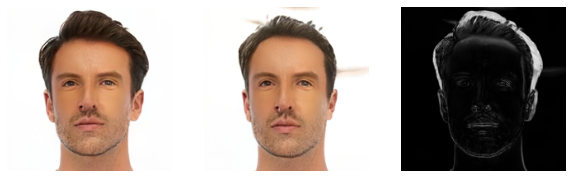

In [156]:
# z = torch.from_numpy(np.random.randn(1, G.z_dim)).to('cuda')
# ws = G.mapping(z,0.7)

v1 = np.load("out/projected_w_yoycol_1.npz")['w']
ws = torch.Tensor(v1).cuda()

print('G'+"\n")
img = G.synthesis(ws, noise_mode='const')
# img = G(z, 2, truncation_psi=0.7, noise_mode='const')
img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
im1 = PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB').resize((200,200))

print("style")
img = G_style.synthesis(ws, noise_mode='const')
# img = G_style(z, 2, truncation_psi=0.7, noise_mode='const')
img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
im2 = PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB').resize((200,200))
print("over")

%matplotlib inline
import  matplotlib.pyplot as plt
from PIL import Image
plt.figure(figsize=(10,5))

plt.subplot(1,3,1)
plt.axis("off")
plt.imshow(im1)

plt.subplot(1,3,2)
plt.axis("off")
plt.imshow(im2)


im_diff = Image.fromarray(np.uint8(np.abs(np.float32(np.array(im2)) - np.float32(np.array(im1))))).convert("L").convert("RGB")
plt.subplot(1,3,3)
plt.axis("off")
plt.imshow(im_diff)

In [5]:
# 随机测试style

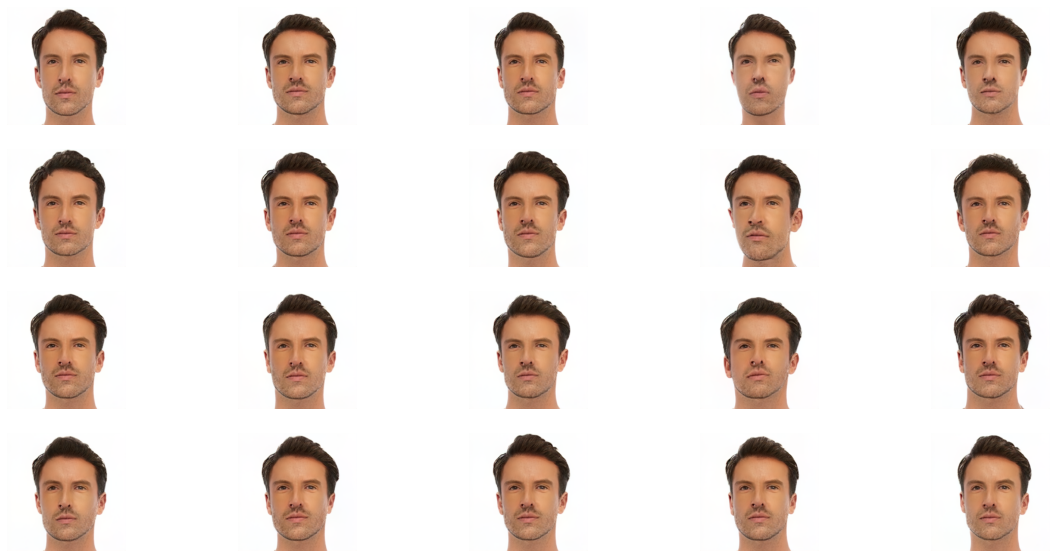

In [90]:
%matplotlib inline
import  matplotlib.pyplot as plt
from PIL import Image
import random
plt.figure(figsize=(20,10))
plt.axis("off")

for k in range(20):
    
    cur_change_dict = {"3":[(160+k,-200)] }
#     cur_change_dict = {"3":[[i,+10] for i in range(500) if random.random() < 0.01]}
    generate_wrap(G_style,cur_change_dict)
    
    img = G_style.synthesis(ws, noise_mode='const')
    # img = G_style(z, 2, truncation_psi=0.7, noise_mode='const')
    img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
    im = PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB').resize((200,200))

    im_diff = Image.fromarray(np.uint8(np.abs(np.float32(np.array(im)) - np.float32(np.array(ori_im))))).convert("L").convert("RGB")
    
    plt.subplot(4,5,k+1)
    plt.axis("off")
    plt.imshow(im)
#     plt.imshow(im_diff)
    


In [78]:
cur_change_dict = {"9":[[i,+40] for i in range(500) if random.random() < 0.01]}
len(cur_change_dict['9'])

5

# backward_hook 获取梯度图

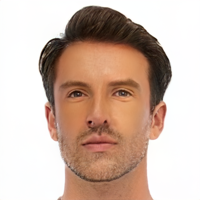

In [92]:
# z = torch.from_numpy(np.random.randn(1, G.z_dim)).to('cuda')
# ws = G.mapping(z,0,truncation_psi=0.7)
img = G.synthesis(ws, noise_mode='random')
# img = G(z, 2, truncation_psi=0.7, noise_mode='random')
img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
ori_im = PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB').resize((200,200))
ori_im

# 注册backward_hook 获取梯度

In [99]:
total_grad = []
def backward_hook(module,grad_in,grad_out):
    total_grad.append(grad_out[0][0])
    
back_handle = []
for block_name in G.synthesis._modules:
    for layer_name in G.synthesis._modules[block_name]._modules:
        cur_handle = G.synthesis._modules[block_name]._modules[layer_name].affine.register_backward_hook(backward_hook)
        back_handle.append(cur_handle)    
#         break
#     break
print(len(back_handle))

26


In [94]:
for h in back_handle:
    h.remove()

In [100]:
from torch.autograd.gradcheck import get_analytical_jacobian,_iter_tensors,_compute_analytical_jacobian_rows,_stack_and_check_tensors
import time
def get_analytical_jacobian(inputs, output):
    diff_input_list = list(_iter_tensors(inputs, True))

    def vjp_fn(grad_output):
        return torch.autograd.grad(output, diff_input_list, grad_output,
                                   retain_graph=True, allow_unused=True)
    # Compute everything twice to check for nondeterminism (which we call reentrancy)
    vjps1 = _compute_analytical_jacobian_rows(vjp_fn, output.clone())

    output_numel = output.numel()
    jacobians1, _, _ = _stack_and_check_tensors(vjps1, inputs, output_numel)
    return jacobians1

start_time = time.time()

ws.requires_grad_(True)
total_grad = []

avgpool = nn.AvgPool2d((32, 32), stride=(32, 32))
output = G.synthesis(ws, noise_mode='const')
output_resize = avgpool(output)

res = get_analytical_jacobian(ws,output_resize[:,0,:,:])

print("total_cost:",time.time() - start_time)
print("total_output_size:", len(total_grad) / len(back_handle),len(back_handle))
# grad = res[0][0][1]
# grad = grad.detach().cpu().numpy()
# Image.fromarray(np.uint8(np.where(grad.reshape(32,32) > 0,0,255))).resize((200,200))

/root/anaconda3/lib/python3.8/site-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/root/anaconda3/lib/python3.8/site-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/root/anaconda3/lib/python3.8/site-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when

total_cost: 24.19263744354248
total_output_size: 1024.0 26


In [101]:
# grad = np.array(list(reversed(total_grad))) # 26 layers * 1024 position # channel
# 梯度转换
grad = np.array((total_grad)) # 26 layers * 1024 position # channel

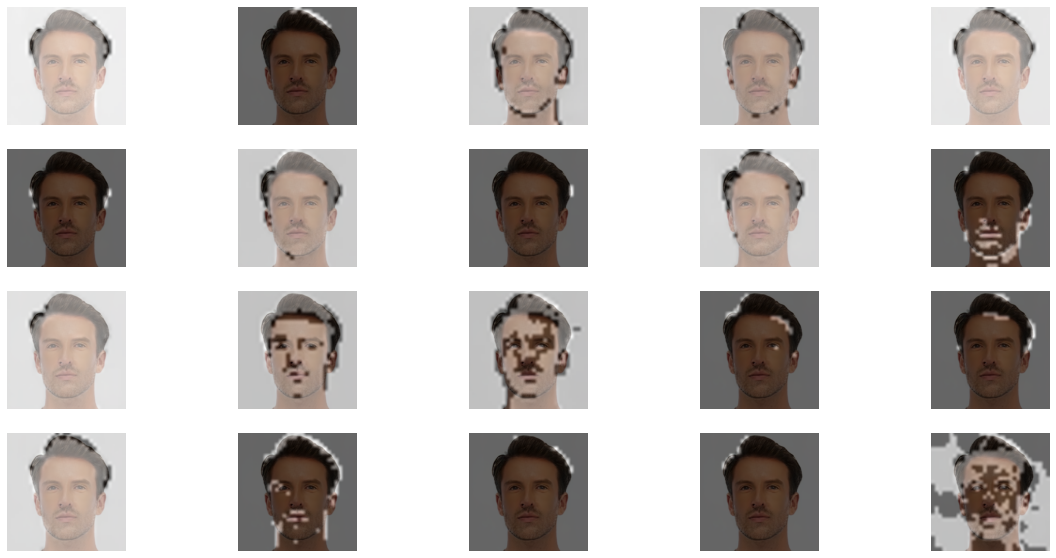

In [130]:
%matplotlib inline
import  matplotlib.pyplot as plt
from PIL import Image
plt.figure(figsize=(20,10))
plt.axis("off")
index = 3
# index = 25 - index
for k in range(20):
    
#     grad = res[0][0][i+512 * 3]
#     grad = grad.detach().cpu().numpy()
#     img = Image.fromarray(np.uint8(np.where(grad.reshape(32,32) > 0,0,255))).resize((200,200))
#     gradient_map = np.array([grad[26*i + index][k] for i in range(1024)])
    gradient_map = np.array([grad[26*i + 25 - index][k].detach().cpu().numpy() for i in range(1024)])
    

    gradient_heat_map = np.uint8((gradient_map - np.min(gradient_map)) / (np.max(gradient_map) - np.min(gradient_map)) * 255).reshape(32,32)
    gradient_binary_map = np.uint8(np.where(gradient_heat_map > 150 ,gradient_heat_map,0))
    
#     gradient_im = Image.fromarray(gradient_heat_map).resize((200,200))
    gradient_im = Image.fromarray(gradient_binary_map).resize((200,200))
    
    gradient_blend = Image.blend(gradient_im.convert("RGB"),ori_im,0.4)


#     index = i + 512 * 0
#     grad = np.array([i[index].detach().cpu().numpy() for i in total_grad])
#     img = Image.fromarray(np.uint8(np.where(grad.reshape(32,32) > -0.002 ,0,255))).resize((200,200))
#     res = Image.blend(img.convert("RGB"),ori_im,0.5)
    
    plt.subplot(4,5,k+1)
    plt.axis("off")
    plt.imshow(gradient_blend)
    


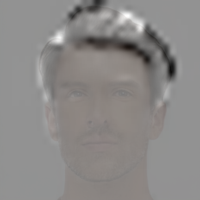

In [116]:
index = 3
channel = 169
hold = 10
gradient_map = np.array([grad[26*i + 25 - index][channel].detach().cpu().numpy() for i in range(1024)])
gradient_heat_map = np.uint8((gradient_map - np.min(gradient_map)) / (np.max(gradient_map) - np.min(gradient_map)) * 255).reshape(32,32)
# gradient_binary_map = np.uint8(np.where(gradient_heat_map > hold ,255,0))
gradient_binary_map = np.uint8(np.where(gradient_heat_map > hold ,gradient_heat_map,0))

gradient_im = Image.fromarray(gradient_binary_map).resize((200,200))
# gradient_im = Image.fromarray(gradient_heat_map).resize((200,200))

gradient_blend = Image.blend(gradient_im.convert("RGB"),ori_im,0.1)
gradient_blend

In [82]:
# 测试

In [13]:
G.synthesis.b8

SynthesisBlock(
  (conv0): SynthesisLayer(
    (affine): FullyConnectedLayer()
  )
  (conv1): SynthesisLayer(
    (affine): FullyConnectedLayer()
  )
  (torgb): ToRGBLayer(
    (affine): FullyConnectedLayer()
  )
)